# Time Series Forecasting 
## Part 1: Getting Started with ML models

In [34]:
# import relevant panckages 
import pandas as pd
import numpy as np

# Financial data time-series
import quandl

# Plotting parameters
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,6)

## (Down)Load Time Series Data 

If you do not have the time series, download it. Else just load it from the `data/` directory. 

In [ ]:
## ----- First Time Download of Data ----------- ##
tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "GM", "GE"]
series = "Close"
# Available options: Open, High, Low, Close, Volume, Adj. Open, Adj. High, Adj. Low, Adj. Close, Adj. Volume

df_price = pd.DataFrame() 

for stck in tickers:
    data = quandl.Dataset("WIKI/{}".format(stck))\
                 .data(params={"start_date":"2002-01-01", "end_date":"2018-07-01"})\
                 .to_pandas()[[series]]\
                 .rename(columns={series:stck})
    df_price = pd.concat([df_price, data], axis=1)

# Make sure there are no dates without closing prices    
df_price = df_price.dropna()

#  Save data 
df_price.to_pickle("data/df_price.pickle")


## ----- Alternative: Load data from Memory ----------- ##
df_price = pd.read_pickle("data/df_price.pickle")
df_price.head()

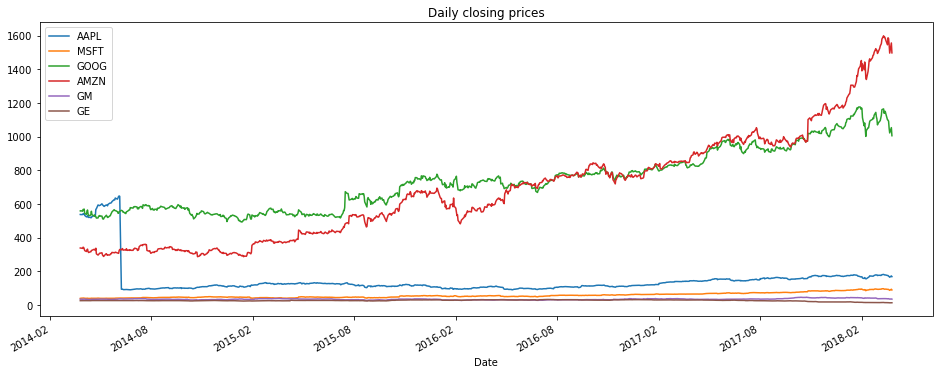

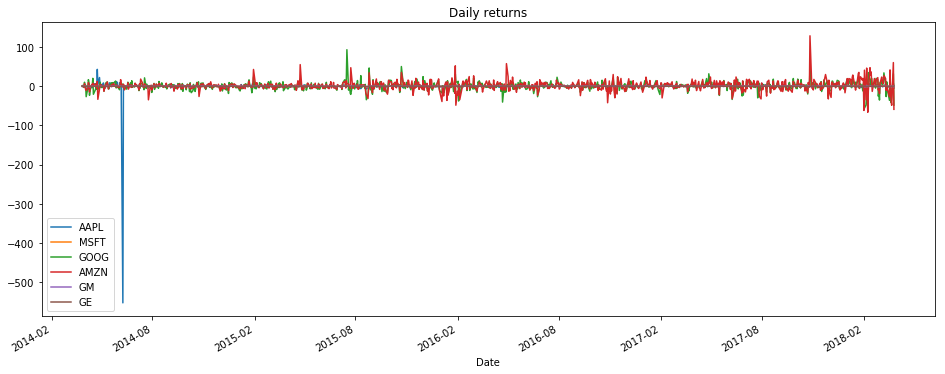

In [35]:
# Visualise Data 
df_price.plot(title="Daily closing prices")
plt.show()

df_price.diff().plot(title="Daily returns")
plt.show()

## Reorganise Data
### Create Label-Feature Pairs

In [329]:
look_ahead = 3 # days
window = 2 # days 
n = len(df_price)

# create label-feature-pairs 
label_feature_pair = []
for stck in df_price:
    timeseries = df_price[stck]
    
    for i in range(n - look_ahead - window+1):
       
        t = (timeseries.index[i+window+look_ahead-1], ) # date 
        
        y_t = (timeseries.iloc[i+window+look_ahead-1], ) # target price
        X_t = tuple(timeseries.iloc[i:i+window])[::-1] # list of features (i.e. previous prices)
        
        label_feature_pair.append(t + (stck,)+  y_t + X_t)

In [ ]:
## Transform into a DataFrame

In [330]:
lagged_cols = ['t-{}'.format(i) for i in range(look_ahead, look_ahead + window)]

data = pd.DataFrame.from_records(label_feature_pair, 
                                 columns=['date', 'stock', 'target'] + lagged_cols, 
                                 index='date')


In [331]:
data.head()

,stock,target,t-3,t-4
date,,,,
2014-04-02,AAPL,542.55,536.86,537.46
2014-04-03,AAPL,538.79,536.74,536.86
2014-04-04,AAPL,531.82,541.65,536.74
2014-04-07,AAPL,523.47,542.55,541.65
2014-04-08,AAPL,523.44,538.79,542.55


## Fit Machine Learning  Models

In [283]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

### Split data into Training and Testing sets 

In [290]:
# Get indices for training and evalutaion sets
train_set, test_set = next(GroupShuffleSplit(n_splits=1, test_size=0.1)\
                                         .split(data, groups=data['stock']))

features =[i for i in data.columns if i not in {'target'}]
label = ['target', 'stock']

y_train, X_train = data.iloc[train_set][label], data.iloc[train_set][features]
y_test, X_test = data.iloc[test_set][label], data.iloc[test_set][features]


### Fit machine learning models

In [293]:
# Elastic Net
model_enet = ElasticNet(fit_intercept=False)
model_enet.fit(X_train.iloc[:, 1:], y_train.iloc[:, 0:1])

# # Gradient Boosting
model_gbr = GradientBoostingRegressor()
model_gbr.fit(X_train.iloc[:, 1:], y_train['target'])

# # Random Forests
model_rnd_frst = RandomForestRegressor()
model_rnd_frst.fit(X_train.iloc[:, 1:], y_train['target'])

C:\Users\kanna sithan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

### Assess Test set performance

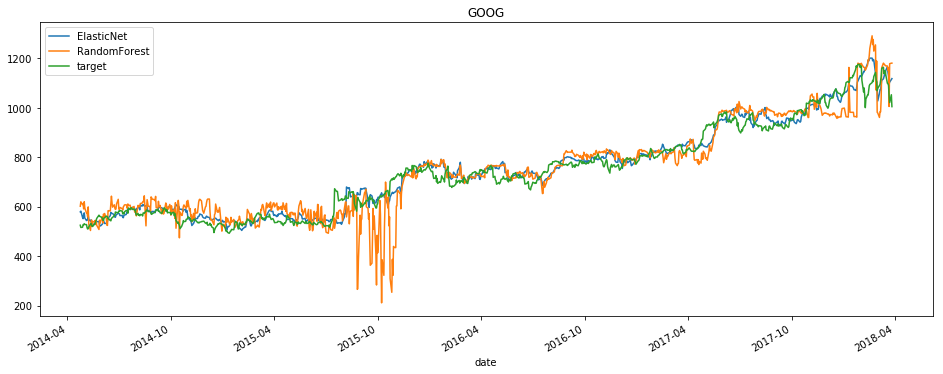

In [294]:
for stck in set(X_test['stock']):
    
    feats = X_test.query("stock == '{}'".format(stck)).iloc[:, 1:]
    labels = y_test.query("stock == '{}'".format(stck))[['target']]
    
    plot_y=  pd.DataFrame({'ElasticNet': model_enet.predict(feats),
                           'RandomForest': model_rnd_frst.predict(feats)},  
                           index=feats.index)\
               .join(labels) 
    
    plot_y.plot(title=stck)
#     plt.xlim(['2017-06-01', '2018-03-01'])
    plt.show()


In [277]:
from sklearn.metrics import r2_score

In [296]:
for model in plot_y:
    print(model, r2_score(y_pred=plot_y[model], y_true=plot_y['target']))

ElasticNet 0.958560473813
RandomForest 0.845245263591
target 1.0
